
# Introduction
In this case study we will be exploring a sample database for a digital media store created using real data from an Apple iTunes library.
We will be answering the following business questions:
1.  How many tracks are sold in the USA by genre?
2.  Which sales support agent has the highest amount of sales within the company?
3.  Which countries have the highest total number of sales?




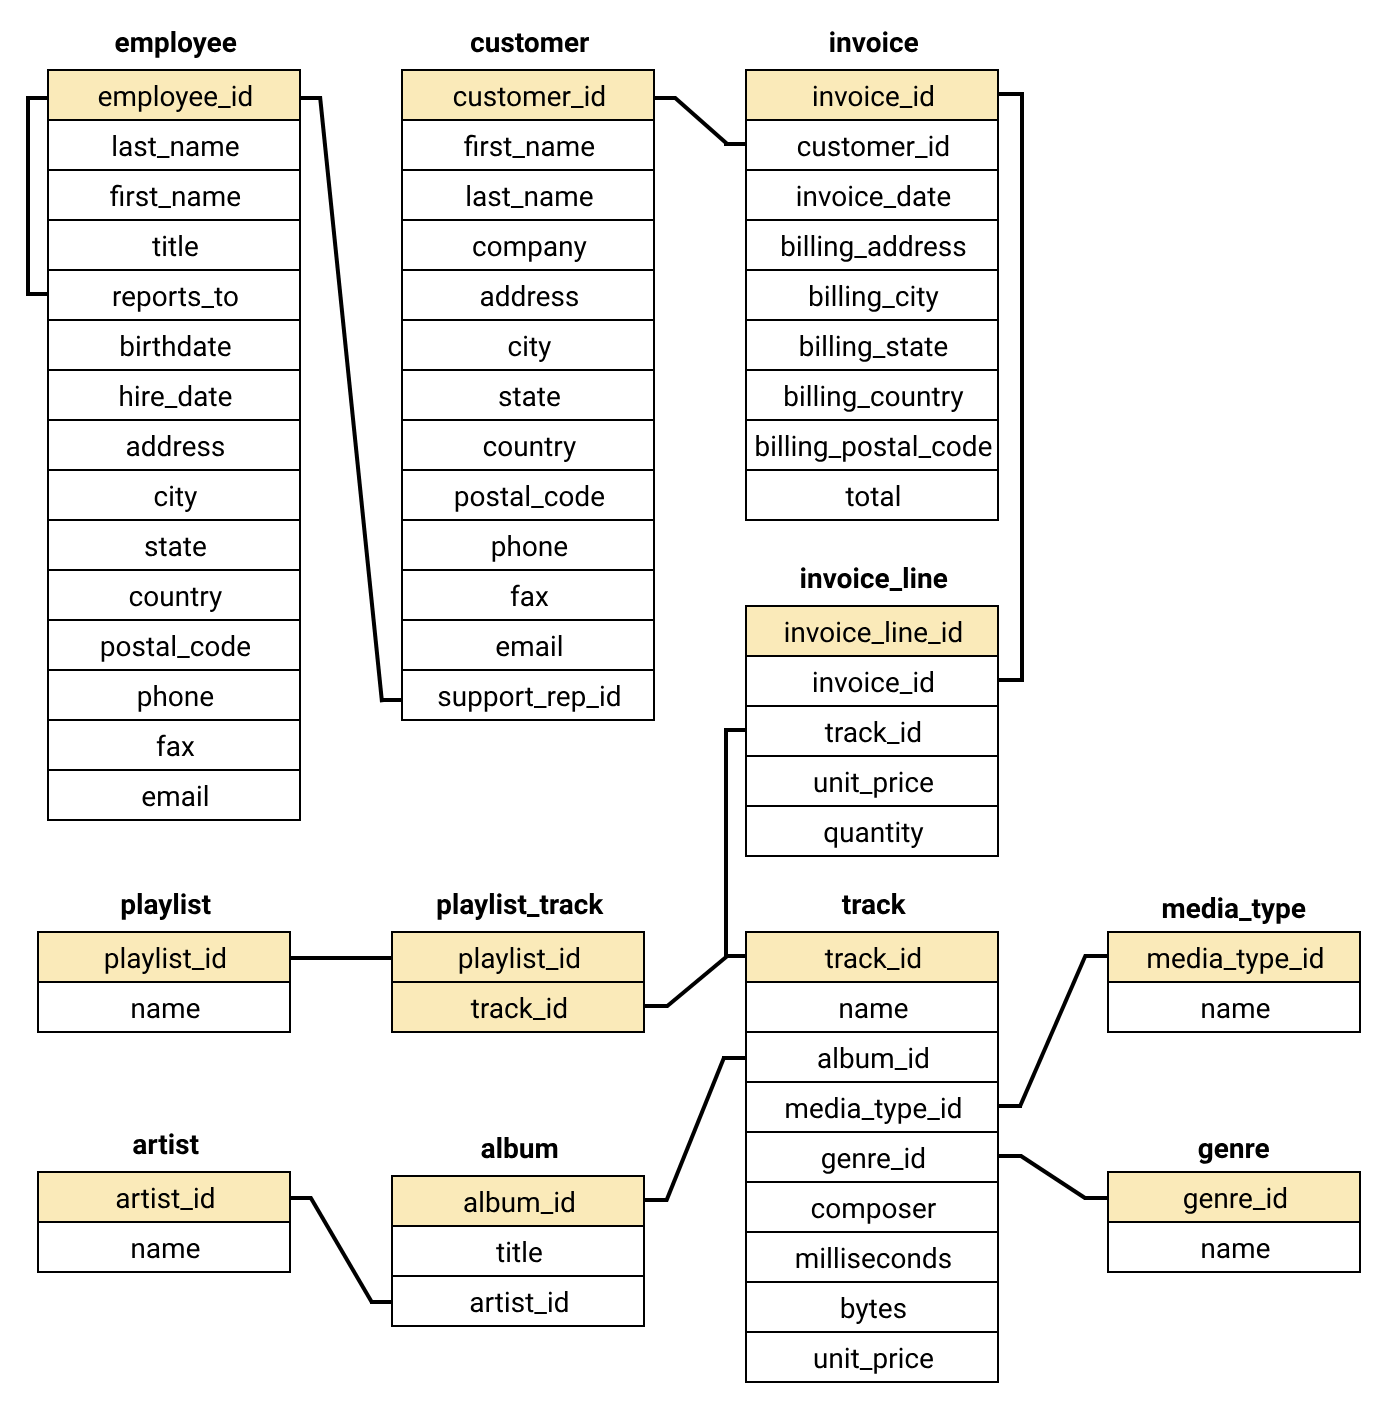 We will use the below code to load the sqlite3 database. 

In [74]:
%reload_ext sql
%sql sqlite:///chinook.db

### How many tracks are sold in the USA by genre?
The below table shows the number tracks sold per genre in the USA. Rock and latin are the most popular genres accounting for over 50% of all sales which should be noted when purchasing new tracks for the store. 

In [73]:
%%sql

WITH
    grouped AS
        (
        SELECT g.name Genre        
        FROM track t
        INNER JOIN invoice_line ii ON ii.invoice_line_id = t.track_id
        INNER JOIN genre g ON g.genre_id = t.genre_id
        INNER JOIN invoice i ON i.invoice_id = ii.invoice_line_id
        INNER JOIN customer c ON c.customer_id = i.customer_id
        WHERE c.country = "USA"
        )
SELECT Genre, 
    COUNT(*) As tracks_sold, 
    ROUND(100.0*COUNT(*)/
          (SELECT COUNT(*) FROM grouped),2) As total_perc
FROM grouped
GROUP BY Genre
ORDER BY COUNT(Genre) desc



 * sqlite:///chinook.db
Done.


Genre,tracks_sold,total_perc
Rock,37,28.24
Latin,36,27.48
Metal,12,9.16
Reggae,11,8.4
Jazz,11,8.4
Alternative & Punk,11,8.4
Blues,5,3.82
Soundtrack,4,3.05
Pop,3,2.29
Rock And Roll,1,0.76


### Which sales support agent has the highest amount of sales within the company?
Jane Peacock has the highest amount of customer sales. Although the data may need to be normalized to account for different lengths of employment to better compare performance. 

In [112]:
%%sql

SELECT e.first_name || ' ' || e.last_name as name, 
    '$' || ROUND(SUM(total),2) as total_sales,
    hire_date
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
WHERE title == 'Sales Support Agent'
GROUP BY employee_id
ORDER BY SUM(total)


 * sqlite:///chinook.db
Done.


name,total_sales,hire_date
Steve Johnson,$1393.92,2017-10-17 00:00:00
Margaret Park,$1584.0,2017-05-03 00:00:00
Jane Peacock,$1731.51,2017-04-01 00:00:00


### Which countries have the highest total number of sales?
Note: we grouped all countries with only 1 customer to the Others category to reduce clutter. 

The largest number of customers from a single country are from the USA, followed by Canada. In total gross sales, the USA also leads, which is unsurprising given that they have the largest number of customers. The average total sales per customer is highest in Canada, followed by the USA. The average order value is highest in the Czech Republic, followed by the United Kingdom.




In [118]:
%%sql
DROP VIEW IF EXISTS customers_by_country;

CREATE VIEW customers_by_country AS
     SELECT country,
            COUNT(*) total_customers
     FROM customer
     GROUP BY country
     ORDER by total_customers;

WITH customers_by_country_other AS
    (
    SELECT *,
           CASE
                WHEN total_customers = 1 THEN "Other"
                ELSE country
           END AS country_other,
           CASE
                WHEN total_customers = 1 THEN 0
                ELSE 1
           END AS country_sort
    FROM customers_by_country
    ),
    customer_invoice AS
    (
    SELECT *,
           (c.first_name || " " || c.last_name) Customer_Name
    FROM customer c
    INNER JOIN invoice i ON i.customer_id = c.customer_id
    ),
    sales_per_customer AS
    (
    SELECT customer_id,
           ROUND(SUM(total) / COUNT(total), 2) AS customer_average
    FROM customer_invoice
    GROUP BY customer_id
    )
    
SELECT cbco.country_other AS country,
       COUNT(DISTINCT ci.Customer_Name) AS total_customers,
       ROUND(SUM(ci.total), 2) AS total_sales,
       spc.customer_average,
       ROUND(SUM(ci.total) / COUNT(ci.total), 2) AS average_order_value
FROM customer_invoice ci
INNER JOIN customers_by_country_other cbco ON cbco.country = ci.country
INNER JOIN sales_per_customer spc ON spc.customer_id = ci.customer_id
GROUP BY cbco.country_other
ORDER BY cbco.country_sort DESC, average_order_value DESC;

 * sqlite:///chinook.db
Done.
Done.
Done.


country,total_customers,total_sales,customer_average,average_order_value
Czech Republic,2,273.24,8.03,9.11
United Kingdom,3,245.52,8.54,8.77
India,2,183.15,8.61,8.72
Germany,4,334.62,7.47,8.16
USA,13,1040.49,9.28,7.94
France,5,389.07,8.8,7.78
Canada,8,535.59,11.11,7.05
Brazil,5,427.68,8.38,7.01
Portugal,2,185.13,7.92,6.38
Other,15,1094.94,8.03,7.45
